# PyTorch를 이용한 AutoEncoder 구현하기


> ## 1. PyTorch를 이용하여 FashionMNIST 데이터셋 로드하기
> ## 2. PyTorch를 이용한 모델 구성하기
> ## 3. PyTorch를 이용한 학습 Loop 구성하기
> ## 4. PyTorch를 이용하여 Inference 하기

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt # Matplotlib: 이미지 출력을 돕는 모듈
from matplotlib import cm # Data 포인트에 색상입히는 용도
import numpy as np # Numpy 행렬 변환

from tqdm import tqdm

In [ ]:
# 하이퍼파라미터
EPOCH = 50
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [ ]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',   # 바지 정장
    2: 'Pullover',  # 스웨터
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 1. PyTorch를 이용하여 FashionMNIST 데이터셋 로드하기

In [ ]:
# Fashion MNIST 데이터셋 다운로드 및 데이터로더 선언
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



# 2. PyTorch를 이용한 모델 구성하기

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2),   # 입력의 특징을 2차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# PyTorch에서는 tensor나 model의 weight를 계산할 장치(device)를 명시해줘야 함
autoencoder = Autoencoder().to(DEVICE)

#최적화 함수 : Adam() --> SGD의 변형, 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 

# MSE(Mean Squared Error) : 평균 제곱 오차
criterion = nn.MSELoss()


In [ ]:
# 원본 이미지를 시각화 하기 (첫번째 열)

view_data = trainset.data[:5].view(-1, 28*28)
view_label = trainset.targets[:5].numpy()

view_data = view_data.type(torch.FloatTensor)/255.
print(view_label)


[9 0 0 3 0]


# 3. PyTorch를 이용한 학습 Loop 구성하기

In [ ]:
def train_one_epoch(autoencoder, train_loader, num_epoch):
    autoencoder.train()

    for x, label in tqdm(train_loader, desc="Epoch: "+str(num_epoch)):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = criterion(decoded, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

Epoch: 1: 100%|██████████| 938/938 [00:12<00:00, 75.78it/s]


[Epoch 1]


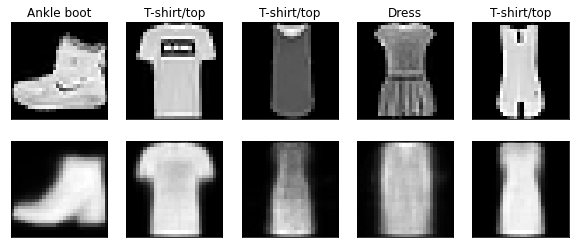

Epoch: 2: 100%|██████████| 938/938 [00:12<00:00, 75.55it/s]


[Epoch 2]


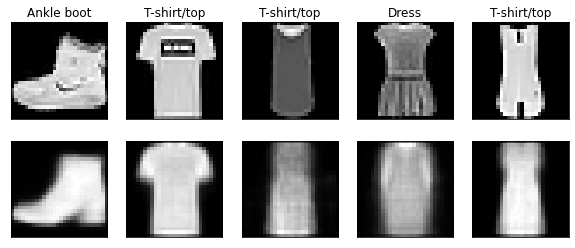

Epoch: 3: 100%|██████████| 938/938 [00:12<00:00, 75.56it/s]


[Epoch 3]


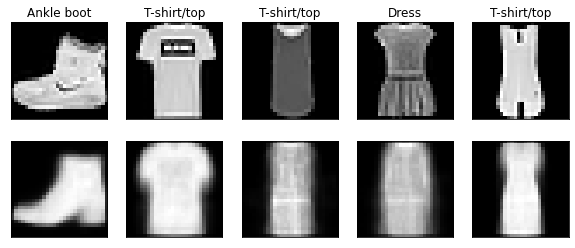

Epoch: 4: 100%|██████████| 938/938 [00:12<00:00, 73.57it/s]


[Epoch 4]


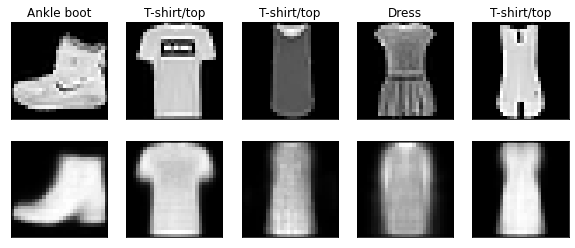

Epoch: 5: 100%|██████████| 938/938 [00:14<00:00, 66.69it/s]


[Epoch 5]


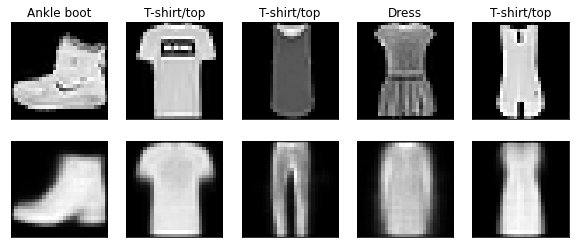

Epoch: 6: 100%|██████████| 938/938 [00:12<00:00, 73.87it/s]


[Epoch 6]


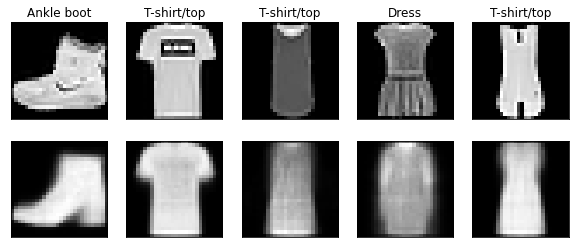

Epoch: 7: 100%|██████████| 938/938 [00:12<00:00, 73.81it/s]


[Epoch 7]


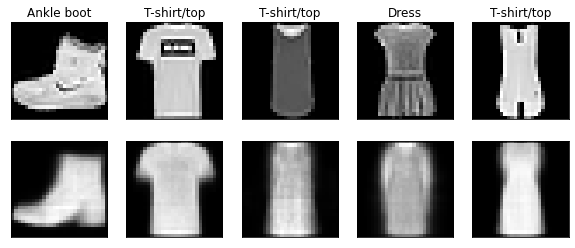

Epoch: 8: 100%|██████████| 938/938 [00:12<00:00, 72.84it/s]


[Epoch 8]


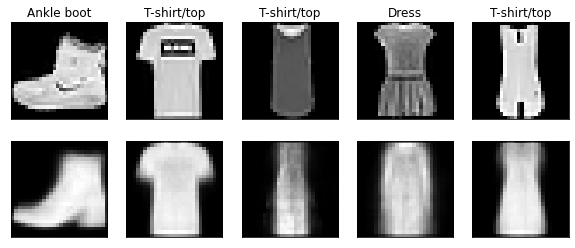

Epoch: 9: 100%|██████████| 938/938 [00:12<00:00, 73.32it/s]


[Epoch 9]


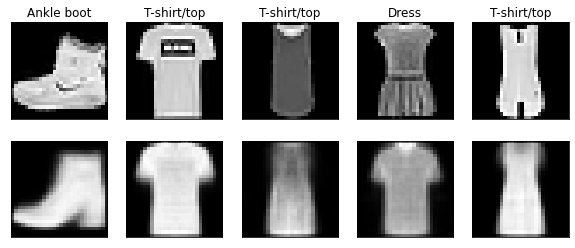

Epoch: 10: 100%|██████████| 938/938 [00:12<00:00, 72.87it/s]


[Epoch 10]


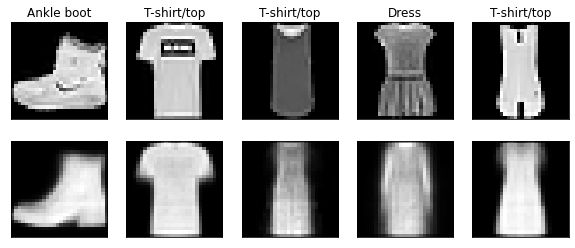

Epoch: 11: 100%|██████████| 938/938 [00:12<00:00, 72.82it/s]


[Epoch 11]


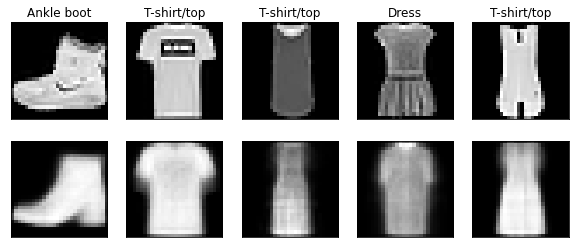

Epoch: 12: 100%|██████████| 938/938 [00:13<00:00, 72.00it/s]


[Epoch 12]


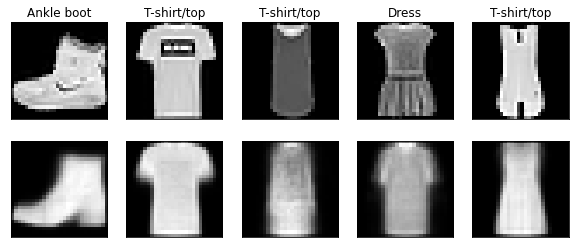

Epoch: 13: 100%|██████████| 938/938 [00:12<00:00, 73.32it/s]


[Epoch 13]


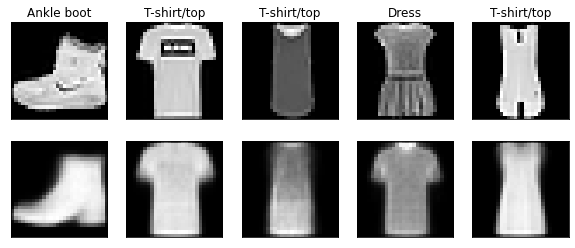

Epoch: 14: 100%|██████████| 938/938 [00:13<00:00, 71.78it/s]


[Epoch 14]


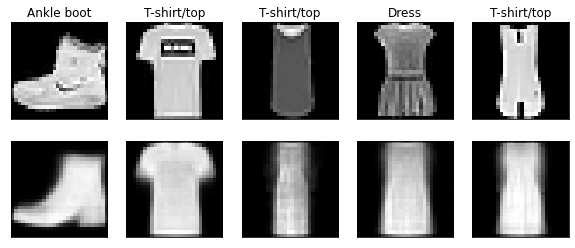

Epoch: 15: 100%|██████████| 938/938 [00:12<00:00, 72.68it/s]


[Epoch 15]


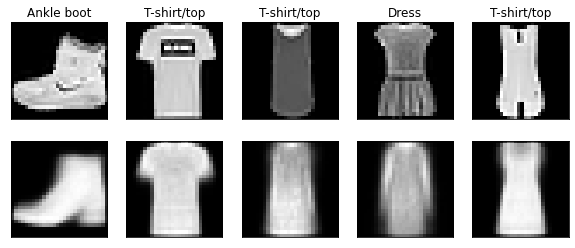

Epoch: 16: 100%|██████████| 938/938 [00:13<00:00, 72.02it/s]


[Epoch 16]


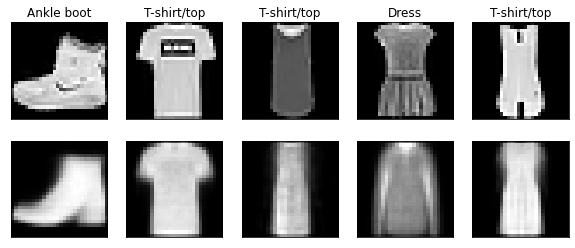

Epoch: 17: 100%|██████████| 938/938 [00:12<00:00, 72.37it/s]


[Epoch 17]


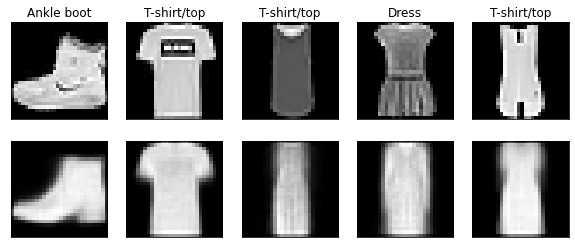

Epoch: 18: 100%|██████████| 938/938 [00:12<00:00, 72.70it/s]


[Epoch 18]


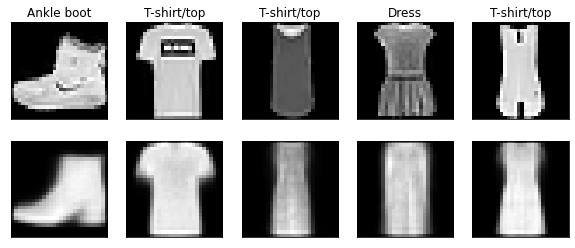

Epoch: 19: 100%|██████████| 938/938 [00:12<00:00, 72.44it/s]


[Epoch 19]


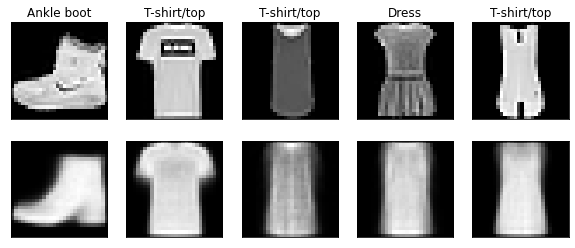

Epoch: 20: 100%|██████████| 938/938 [00:12<00:00, 72.52it/s]


[Epoch 20]


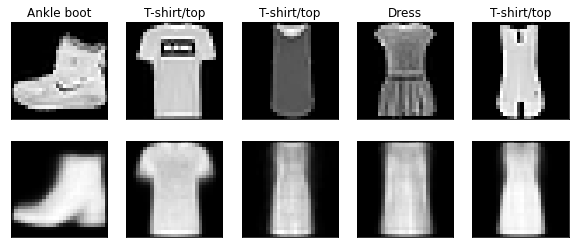

Epoch: 21: 100%|██████████| 938/938 [00:12<00:00, 72.75it/s]


[Epoch 21]


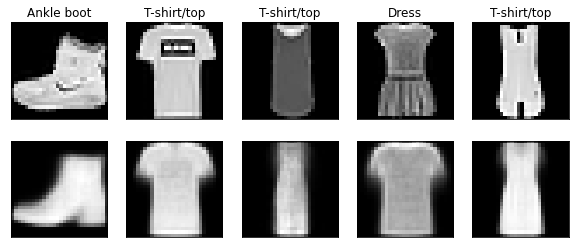

Epoch: 22: 100%|██████████| 938/938 [00:12<00:00, 72.48it/s]


[Epoch 22]


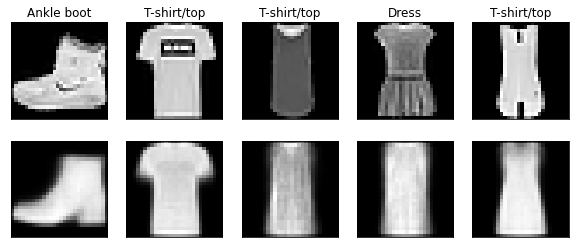

Epoch: 23: 100%|██████████| 938/938 [00:13<00:00, 70.67it/s]


[Epoch 23]


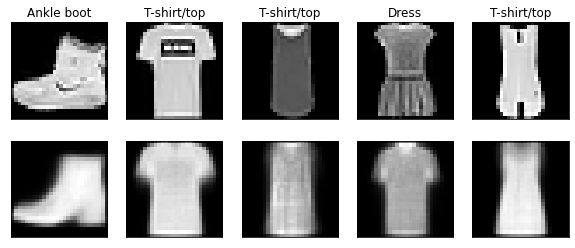

Epoch: 24: 100%|██████████| 938/938 [00:13<00:00, 71.58it/s]


[Epoch 24]


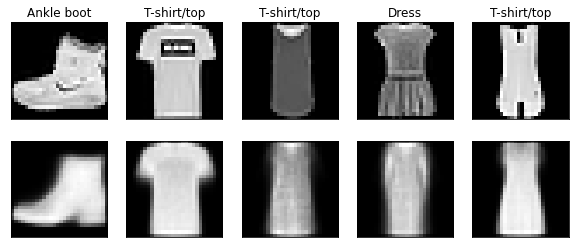

Epoch: 25: 100%|██████████| 938/938 [00:13<00:00, 71.55it/s]


[Epoch 25]


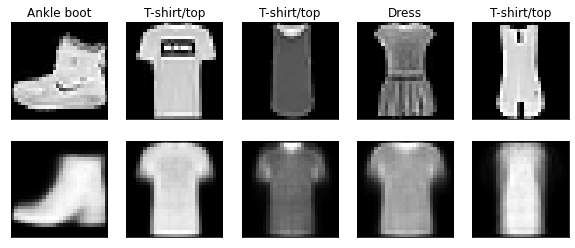

Epoch: 26: 100%|██████████| 938/938 [00:13<00:00, 71.89it/s]


[Epoch 26]


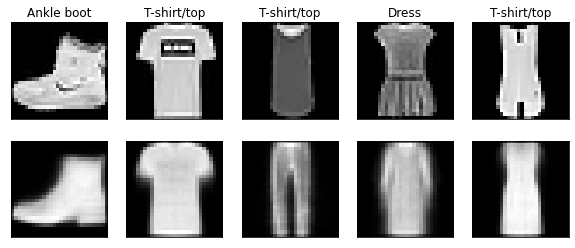

Epoch: 27: 100%|██████████| 938/938 [00:12<00:00, 72.34it/s]


[Epoch 27]


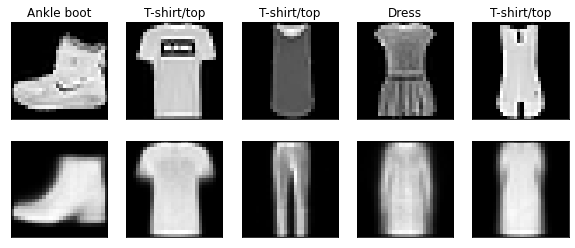

Epoch: 28: 100%|██████████| 938/938 [00:13<00:00, 71.96it/s]


[Epoch 28]


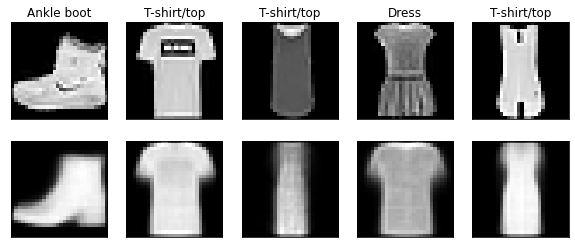

Epoch: 29: 100%|██████████| 938/938 [00:13<00:00, 71.62it/s]


[Epoch 29]


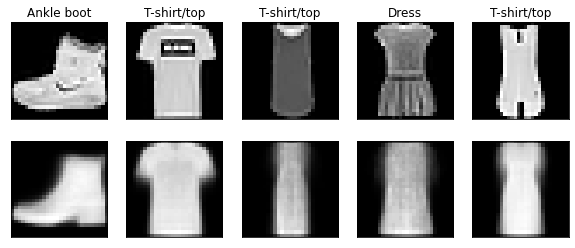

Epoch: 30: 100%|██████████| 938/938 [00:13<00:00, 71.70it/s]


[Epoch 30]


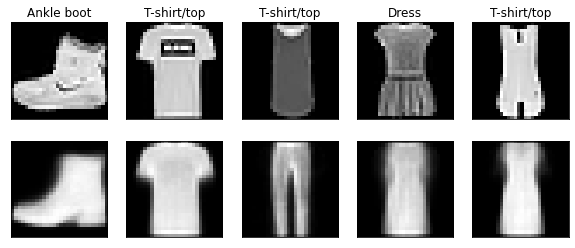

Epoch: 31: 100%|██████████| 938/938 [00:13<00:00, 70.00it/s]


[Epoch 31]


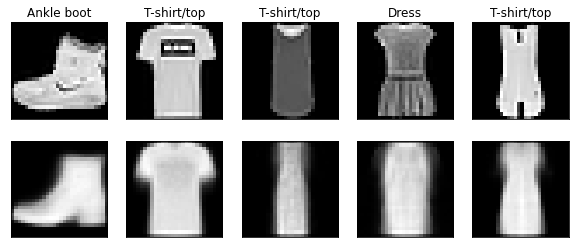

Epoch: 32: 100%|██████████| 938/938 [00:13<00:00, 71.68it/s]


[Epoch 32]


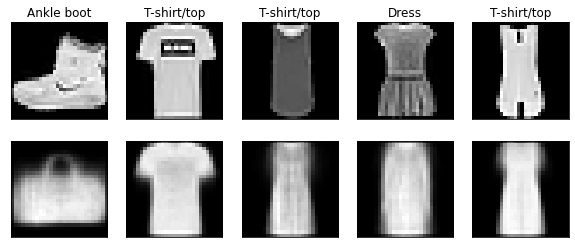

Epoch: 33: 100%|██████████| 938/938 [00:13<00:00, 70.89it/s]


[Epoch 33]


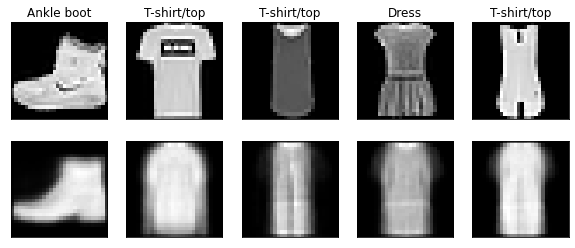

Epoch: 34: 100%|██████████| 938/938 [00:13<00:00, 71.72it/s]


[Epoch 34]


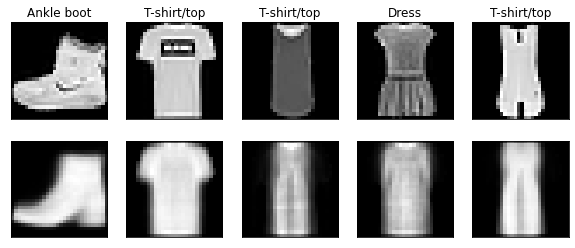

Epoch: 35: 100%|██████████| 938/938 [00:13<00:00, 69.73it/s]


[Epoch 35]


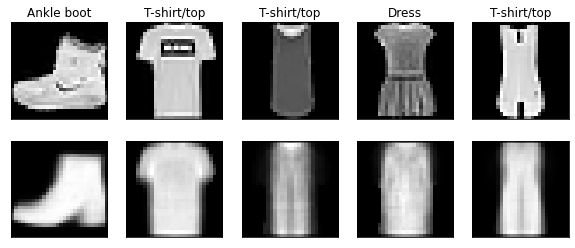

Epoch: 36: 100%|██████████| 938/938 [00:13<00:00, 71.65it/s]


[Epoch 36]


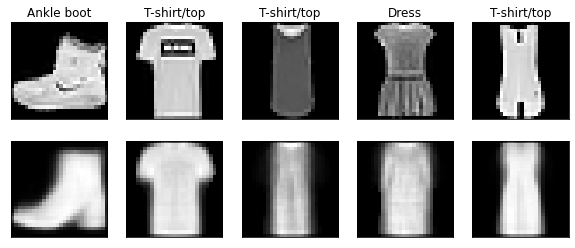

Epoch: 37: 100%|██████████| 938/938 [00:13<00:00, 71.74it/s]


[Epoch 37]


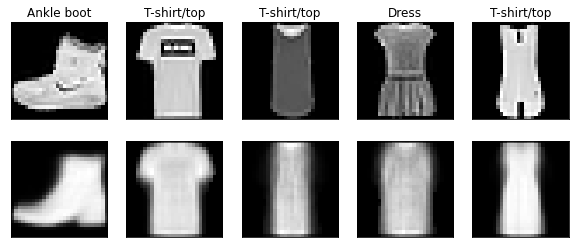

Epoch: 38: 100%|██████████| 938/938 [00:13<00:00, 71.16it/s]


[Epoch 38]


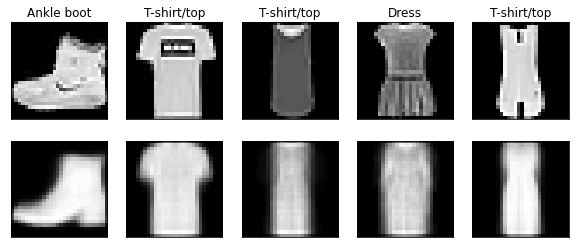

Epoch: 39: 100%|██████████| 938/938 [00:13<00:00, 71.20it/s]


[Epoch 39]


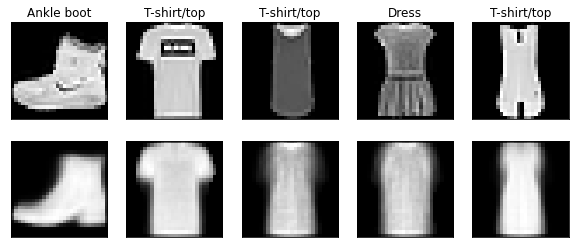

Epoch: 40: 100%|██████████| 938/938 [00:13<00:00, 71.63it/s]


[Epoch 40]


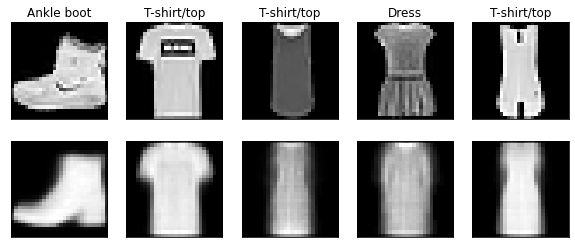

Epoch: 41: 100%|██████████| 938/938 [00:13<00:00, 71.56it/s]


[Epoch 41]


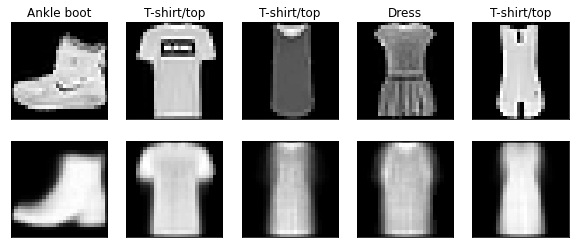

Epoch: 42: 100%|██████████| 938/938 [00:13<00:00, 71.61it/s]


[Epoch 42]


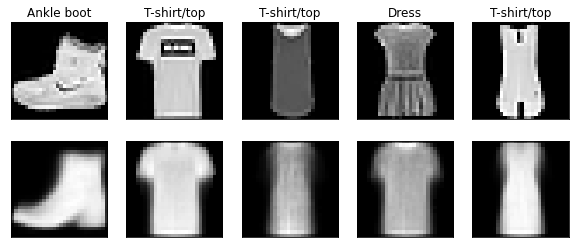

Epoch: 43: 100%|██████████| 938/938 [00:13<00:00, 69.72it/s]


[Epoch 43]


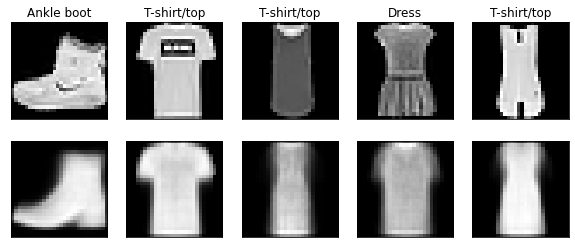

Epoch: 44: 100%|██████████| 938/938 [00:13<00:00, 71.32it/s]


[Epoch 44]


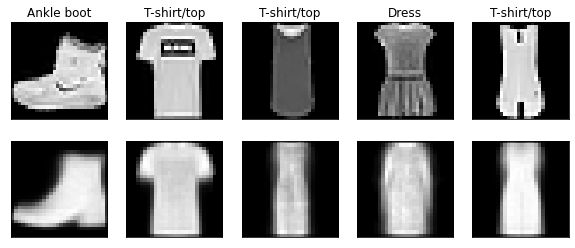

Epoch: 45: 100%|██████████| 938/938 [00:13<00:00, 71.12it/s]


[Epoch 45]


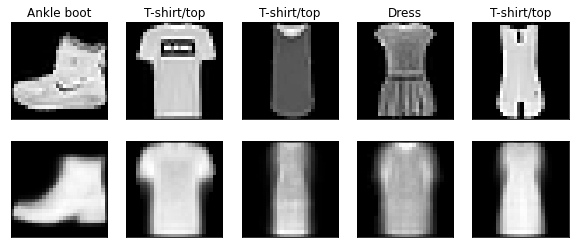

Epoch: 46: 100%|██████████| 938/938 [00:13<00:00, 70.92it/s]


[Epoch 46]


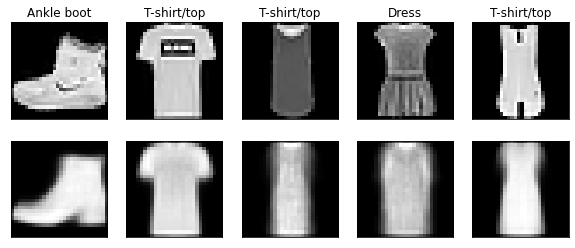

Epoch: 47: 100%|██████████| 938/938 [00:13<00:00, 70.42it/s]


[Epoch 47]


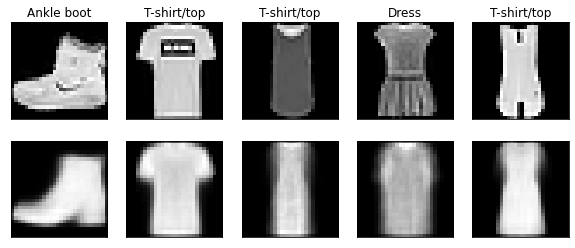

Epoch: 48: 100%|██████████| 938/938 [00:13<00:00, 70.44it/s]


[Epoch 48]


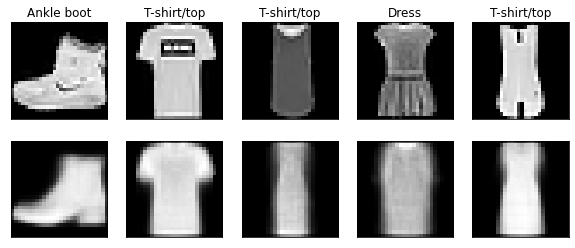

Epoch: 49: 100%|██████████| 938/938 [00:13<00:00, 70.97it/s]


[Epoch 49]


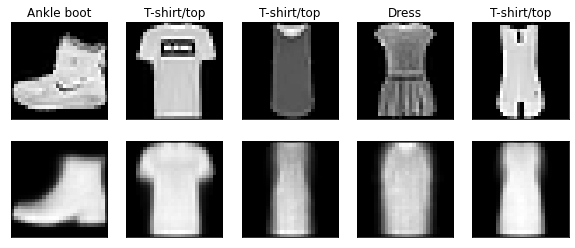

Epoch: 50: 100%|██████████| 938/938 [00:13<00:00, 70.75it/s]


[Epoch 50]


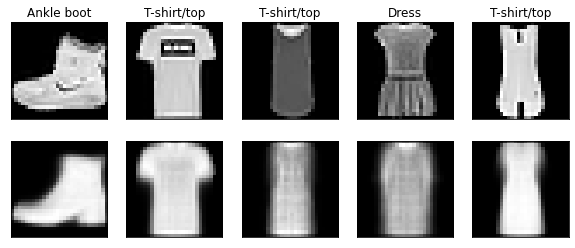

In [ ]:
for epoch in range(1, EPOCH+1):
    train_one_epoch(autoencoder, train_loader, num_epoch=epoch)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(10, 4))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        a[0][i].set_title(CLASSES[view_label[i]])

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()


# 4. PyTorch를 이용하여 Inference 하기

In [ ]:
# 잠재변수를 플롯으로 시각화
autoencoder.eval()

view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

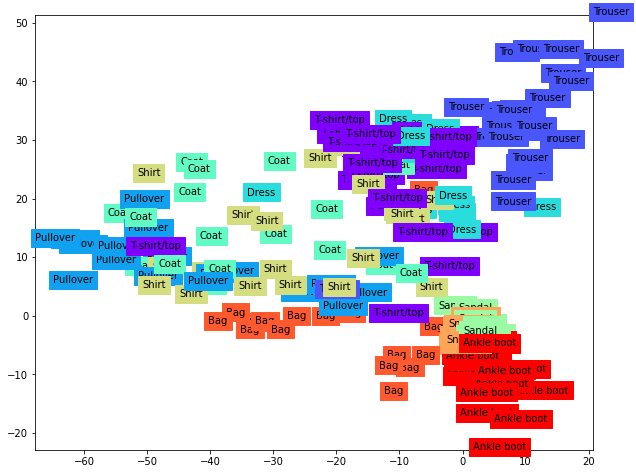

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,8))

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()

labels = trainset.targets[:200].numpy()

for x, y, s in zip(X, Y, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    plt.text(x, y, name, backgroundcolor=color)

plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.show()